# Code vectorization
[LINK](https://www.labri.fr/perso/nrougier/from-python-to-numpy/)

## INDICAÇÕES

### Mensagem
* Quem deseja participar na tradução deste tutorial, pode-me enviar um email a ** jlasam001@gmail.com ** informando sua disponibilidade para a tarefa de tradução. Cabe indicar que o aluno participante da tradução do documento ganhara 1 ponto extra.

### Dicas execução
* Carregue todos os pacotes que serão necessários no início do arquivo.
* Para executar comandos da shell dentro do notebook, utilize o prefixo `!` antes do comando de shell. (e.g. para listar os arquivos da pasta atual faça `! ls` para UNIX ou `! dir` para Windows.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

%matplotlib inline

## Introduction <a name="SobOptTensorFlow"></a>




Code vectorization means that the problem you're trying to solve is inherently vectorizable and only requires a few numpy tricks to make it faster. 
Of course it does not mean it is easy nor straightforward, but at least it does not necessitate to totally rethink your problem (as it will be the case in the
Problem vectorization chapter). 
Still, it may require some experience to see where code can be vectorized. 

Let's illustrate this through the most simple example where we want to sum up two lists of integers. 
One simple way using pure Python is:

In [0]:
def add_python(Z1,Z2):
  return [z1+z2 for (z1,z2) in zip(Z1,Z2)]

This first naive solution can be vectorized very easily using numpy:

In [0]:
def add_numpy(Z1,Z2):
  return np.add(Z1,Z2)

Without any surprise, benchmarking the two approaches shows the second method is the fastest with one order of magnitude.

In [9]:
start_time = time.time()
Z1 = random.sample(range(1000), 100)
Z2 = random.sample(range(1000), 100)

start_time = time.time()
Zs = add_python(Z1, Z2)
time_list = time.time() - start_time

start_time = time.time()
Zs = add_numpy(Z1, Z2)
time_vect = time.time() - start_time

print(time_list/time_vect)


0.38813559322033897


Not only is the second approach faster, but it also naturally adapts to the shape of `Z1` and `Z2`. 
* This is the reason why we did not write `Z1 + Z2` because it would not work if `Z1` and `Z2` were both lists. 

In the first Python method, the inner `+` is interpreted differently depending on the nature of the two objects such that if we consider two nested lists, we get the following outputs:

In [10]:
Z1 = [[1, 2], [3, 4]]
Z2 = [[5, 6], [7, 8]]
Zs1 = Z1 + Z2
print(Zs1)
Zs2 = add_python(Z1, Z2)
print(Zs2)
Zs3 = add_numpy(Z1, Z2)
print(Zs3)

[[1, 2], [3, 4], [5, 6], [7, 8]]
[[1, 2, 5, 6], [3, 4, 7, 8]]
[[ 6  8]
 [10 12]]


* **The first method** concatenates the two lists together, 
* **The second method** concatenates the internal lists together and 
* **The last one** computes what is (numerically) expected. 

As an exercise, you can rewrite the Python version such that it accepts nested lists of any depth.

## Uniform vectorization

---

**Uniform vectorization** is the simplest form of vectorization where all the elements share the same computation at every time step with no specific processing for any element. 

---

One stereotypical case is the **Game of Life** that has been invented by John Conway (see below) and is one of the earliest examples of **cellular automata**. 
* Those cellular automata can be conveniently regarded as an array of cells that are connected together with the notion of neighbours and their vectorization is straightforward. 

Let me first define the game and we'll see how to vectorize it.

**Figure 1**. Conus textile snail exhibits a cellular automaton pattern on its shell.  
<img src='https://drive.google.com/uc?id=1zw6zaPKoLOlhCKDv80fRxDWqq6mdkXNX'>

### The Game of Life

The Game of Life is a cellular automaton devised by the British mathematician John Horton Conway in 1970. 
It is the best-known example of a **cellular automaton**. 
The *game* is actually a **zero-player game**, meaning that its evolution is determined by its **initial state**, needing no input from human players. 
One interacts with the Game of Life by **creating an initial configuration and observing how it evolves**.

The universe of the Game of Life is an **infinite two-dimensional orthogonal grid of square cells**, each of which is in one of two possible states, **live** or
**dead**. 
Every cell interacts with its **eight neighbours**, which are the cells that are directly horizontally, vertically, or diagonally adjacent. 
At each step in time, the following transitions occur:

1. Any live cell with fewer than two live neighbours dies, as if by needs caused by underpopulation.
2. Any live cell with more than three live neighbours dies, as if by overcrowding.
3. Any live cell with two or three live neighbours lives, unchanged, to the next generation.
4. Any dead cell with exactly three live neighbours becomes a live cell.

The initial pattern constitutes the *seed* of the system. 
The first generation is created by applying the above rules simultaneously to every cell in the seed
* births and deaths happen simultaneously, and the discrete moment at which this happens is sometimes called a *tick*. (In other words, each generation is a pure function of the one before.) 
The rules continue to be applied repeatedly to create further generations.

### Python implementation

In pure Python, we can code the Game of Life using a list of lists representing the board where cells are supposed to evolve. 
Such a board will be equipped with border of $0$ that allows to accelerate things a bit by avoiding to have specific tests for borders when counting the number of neighbours.

In [0]:
Z = [[0,0,0,0,0,0],
     [0,0,0,1,0,0],
     [0,1,0,1,0,0],
     [0,0,1,1,0,0],
     [0,0,0,0,0,0],
     [0,0,0,0,0,0]]

Taking the border into account, **counting neighbours** then is straightforward:

In [0]:
def compute_neighbours(Z):
       shape = len(Z), len(Z[0])
       N  = [[0,]*(shape[0]) for i in range(shape[1])]
       for x in range(1,shape[0]-1):
           for y in range(1,shape[1]-1):
               N[x][y] = Z[x-1][y-1]+Z[x][y-1]+Z[x+1][y-1] \
                       + Z[x-1][y]            +Z[x+1][y]   \
                       + Z[x-1][y+1]+Z[x][y+1]+Z[x+1][y+1]
       return N

To iterate one step in time, we then simply count the number of neighbours for each internal cell and we update the whole board according to the four aforementioned rules:

In [0]:
def iterate(Z):
       N = compute_neighbours(Z)
       for x in range(1,shape[0]-1):
           for y in range(1,shape[1]-1):
                if Z[x][y] == 1 and (N[x][y] < 2 or N[x][y] > 3):
                    Z[x][y] = 0
                elif Z[x][y] == 0 and N[x][y] == 3:
                    Z[x][y] = 1
       return Z

The figure below shows four iterations on a $4 \times 4$ area where the initial state is a
[glinder](https://en.wikipedia.org/wiki/Glider_(Conway%27s_Life), a structure
discovered by Richard K. Guy in 1970.

**Figure 2**. The glider pattern is known to replicate itself one step diagonally in 4
   iterations.
<img src =   'https://drive.google.com/uc?id=19LsCILRURFdEvZ_DB5DqXddpaFcVKEzh'>

### Numpy implementation

Starting from the Python version, the vectorization of the Game of Life requires two parts, 
1. one responsible for counting the neighbours and 
1. one responsible for enforcing the rules. 

Neighbour-counting is relatively easy if we remember we took care of adding a null border around the arena. 
By considering partial views of the arena we can actually access neighbours quite intuitively as illustrated below for the one-dimensional case:

<img src = 'https://drive.google.com/uc?id=19fUcUBRRTK145DsHb9nJR2NmyvAtdC_5'>

Going to the two dimensional case requires just a bit of arithmetic to make sure to consider all the eight neighbours.


In [0]:
N = np.zeros(Z.shape, dtype=int)
   N[1:-1,1:-1] += (Z[ :-2, :-2] + Z[ :-2,1:-1] + Z[ :-2,2:] +
                    Z[1:-1, :-2]                + Z[1:-1,2:] +
                    Z[2:  , :-2] + Z[2:  ,1:-1] + Z[2:  ,2:])

For the rule enforcement, we can write a first version using numpy's
[argwhere](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argwhere.html)
method that will give us the indices where a given condition is True.


In [0]:
# Flatten arrays
N_ = N.ravel()
Z_ = Z.ravel()

# Apply rules
R1 = np.argwhere( (Z_==1) & (N_ < 2) )
R2 = np.argwhere( (Z_==1) & (N_ > 3) )
R3 = np.argwhere( (Z_==1) & ((N_==2) | (N_==3)) )
R4 = np.argwhere( (Z_==0) & (N_==3) )

# Set new values
Z_[R1] = 0
Z_[R2] = 0
Z_[R3] = Z_[R3]
Z_[R4] = 1

# Make sure borders stay null
Z[0,:] = Z[-1,:] = Z[:,0] = Z[:,-1] = 0

Even if this first version does not use nested loops, it is far from optimal because of the use of the four `argwhere` calls that may be quite slow. 
We can instead factorize the rules into cells that will survive (stay at 1) and cells that will give birth. 
For doing this, we can take advantage of **Numpy boolean capability** and write quite naturally:

---

**Note** 
We did no write `Z = 0` as this would simply assign the value 0 to `Z` that would then become a simple scalar.

---

In [0]:
birth = (N==3) & (Z[1:-1,1:-1]==0)
survive = ((N==2) | (N==3)) & (Z[1:-1,1:-1]==1)
Z[...] = 0
Z[1:-1,1:-1][birth | survive] = 1

If you look at the `birth` and `survive` lines, you'll see that these two variables are arrays that can be used to set `Z` values to 1 after having cleared it.

**Figure 3**. The Game of Life. Gray levels indicate how much a cell has been active in
   the past.
<img src='https://drive.google.com/uc?id=1BvefWxvhyiOTA34SePssBw_N6E-aqWnx'>


   

### Exercise

Reaction and diffusion of chemical species can produce a variety of patterns, reminiscent of those often seen in nature. 
**The Gray-Scott equations model** such a reaction. 
* For more information on this chemical system see the article **Complex Patterns in a Simple System**
(John E. Pearson, Science, Volume 261, 1993). 

Let's consider two chemical species : 
* $U$ and $V$ with respective concentrations $u$ and $v$ and diffusion rates $Du$ and $Dv$. 
* $V$ is converted into $P$ with a rate of conversion $k$. 
* $f$ represents the rate of the process that feeds $U$ and drains $U$, $V$ and $P$. 
This can be written as:

|Chemical reaction| - - - - - - - - - - Equations - - - - - - - - - - |
|---|----|
|$U + 2V  \rightarrow 3V$ |$\dot{u} = Du \nabla^2 u - uv^2 + f(1-u)$ |
|$V  \rightarrow P$ | $\dot{v} = Dv \nabla^2 v + uv^2 - (f+k)v$ |

Based on the Game of Life example, try to implement such reaction-diffusion system.
Here is a set of interesting parameters to test:

|Name|$Du$|$Dv$|$f$|$k$|
|---|---|---|---|---|
|Bacteria 1|0.16|0.08|0.035|0.065|
|Bacteria 2 |   0.14 | 0.06 | 0.035 | 0.065|
|Coral         |0.16 | 0.08 | 0.060 | 0.062|
|Fingerprint|   0.19 | 0.05 | 0.060 | 0.062|
|Spirals       |0.10 | 0.10 | 0.018 | 0.050|
|Spirals Dense| 0.12 | 0.08 | 0.020 | 0.050|
|Spirals Fast | 0.10 | 0.16 | 0.020 | 0.050|
|Unstable      |0.16 | 0.08 | 0.020 | 0.055|
|Worms 1       |0.16 | 0.08 | 0.050 | 0.065|
|Worms 2       |0.16|  0.08 | 0.054 | 0.063|
|Zebrafish     |0.16|  0.08 | 0.035 | 0.060|


### Sources

[game-of-life-python.py](code/game-of-life-python.py)

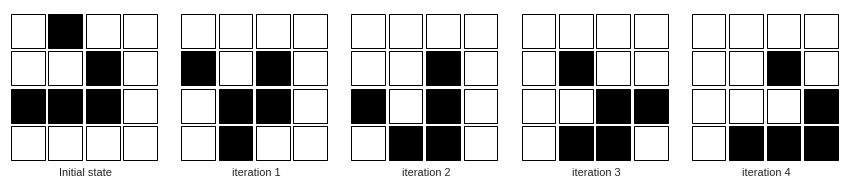

In [1]:
# -----------------------------------------------------------------------------
# From Numpy to Python
# Copyright (2017) Nicolas P. Rougier - BSD license
# More information at https://github.com/rougier/numpy-book
# -----------------------------------------------------------------------------

def compute_neighbours(Z):
    shape = len(Z), len(Z[0])
    N = [[0, ]*(shape[0]) for i in range(shape[1])]
    for x in range(1, shape[0]-1):
        for y in range(1, shape[1]-1):
            N[x][y] = Z[x-1][y-1]+Z[x][y-1]+Z[x+1][y-1] \
                    + Z[x-1][y]            +Z[x+1][y]   \
                    + Z[x-1][y+1]+Z[x][y+1]+Z[x+1][y+1]
    return N


def iterate(Z):
    shape = len(Z), len(Z[0])

    N = compute_neighbours(Z)
    for x in range(1, shape[0]-1):
        for y in range(1, shape[1]-1):
            if Z[x][y] == 1 and (N[x][y] < 2 or N[x][y] > 3):
                Z[x][y] = 0
            elif Z[x][y] == 0 and N[x][y] == 3:
                Z[x][y] = 1
    return Z

if __name__ == '__main__':
    from matplotlib.patches import Rectangle

    Z = [[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0],
         [0, 1, 0, 1, 0, 0],
         [0, 0, 1, 1, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]]

    figure = plt.figure(figsize=(12, 3))

    labels = ("Initial state",
              "iteration 1", "iteration 2",
              "iteration 3", "iteration 4")

    for i in range(5):
        ax = plt.subplot(1, 5, i+1, aspect=1, frameon=False)

        for x in range(1, 5):
            for y in range(1, 5):
                if Z[x][y] == 1:
                    facecolor = 'black'
                else:
                    facecolor = 'white'
                rect = Rectangle((x, 5-y), width=0.9, height=0.9,
                                 linewidth=1.0, edgecolor='black',
                                 facecolor=facecolor)
                ax.add_patch(rect)
        ax.set_xlim(.9, 5.1)
        ax.set_ylim(.9, 5.1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(labels[i])

        for tick in ax.xaxis.get_major_ticks():
            tick.tick1On = tick.tick2On = False
        for tick in ax.yaxis.get_major_ticks():
            tick.tick1On = tick.tick2On = False

        iterate(Z)

    plt.tight_layout()
    plt.savefig("glider.png")
    plt.show()


[game-of-life-numpy.py](code/game-of-life-numpy.py)


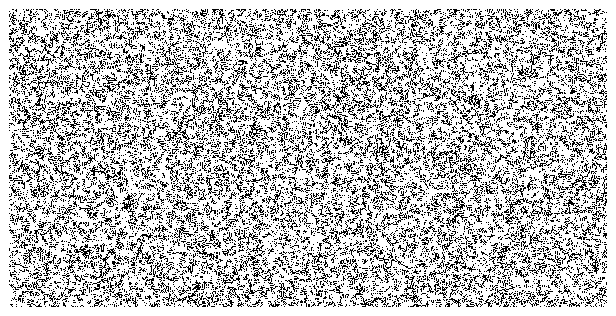

In [5]:
# -----------------------------------------------------------------------------
# From Numpy to Python
# Copyright (2017) Nicolas P. Rougier - BSD license
# More information at https://github.com/rougier/numpy-book
# -----------------------------------------------------------------------------
from matplotlib.animation import FuncAnimation


def update(*args):
    global Z, M

    N = (Z[0:-2, 0:-2] + Z[0:-2, 1:-1] + Z[0:-2, 2:] +
         Z[1:-1, 0:-2]                 + Z[1:-1, 2:] +
         Z[2:  , 0:-2] + Z[2:  , 1:-1] + Z[2:  , 2:])
    birth = (N == 3) & (Z[1:-1, 1:-1] == 0)
    survive = ((N == 2) | (N == 3)) & (Z[1:-1, 1:-1] == 1)
    Z[...] = 0
    Z[1:-1, 1:-1][birth | survive] = 1

    # Show past activities
    M[M>0.25] = 0.25
    M *= 0.995
    M[Z==1] = 1
    # Direct activity
    # M[...] = Z
    im.set_data(M)


Z = np.random.randint(0, 2, (300, 600))
M = np.zeros(Z.shape)

size = np.array(Z.shape)
dpi = 80.0
figsize = size[1]/float(dpi), size[0]/float(dpi)
fig = plt.figure(figsize=figsize, dpi=dpi)
fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False)
im = plt.imshow(M, interpolation='nearest', cmap=plt.cm.gray_r, vmin=0, vmax=1)
plt.xticks([]), plt.yticks([])

animation = FuncAnimation(fig, update, interval=10, frames=2000)
# animation.save('game-of-life.mp4', fps=40, dpi=80, bitrate=-1, codec="libx264",
#                extra_args=['-pix_fmt', 'yuv420p'],
#                metadata={'artist':'Nicolas P. Rougier'})
plt.show()


[gray-scott.py](code/gray-scott.py) (solution to the exercise)

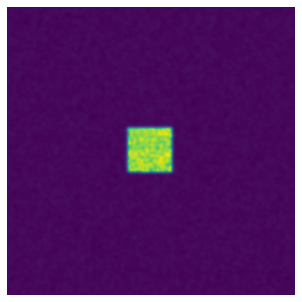

In [8]:
# -----------------------------------------------------------------------------
# From Numpy to Python
# Copyright (2017) Nicolas P. Rougier - BSD license
# More information at https://github.com/rougier/numpy-book
# -----------------------------------------------------------------------------
from matplotlib.animation import FuncAnimation


# Parameters from http://www.aliensaint.com/uo/java/rd/
# -----------------------------------------------------
n = 256
Du, Dv, F, k = 0.16, 0.08, 0.035, 0.065  # Bacteria 1
# Du, Dv, F, k = 0.14, 0.06, 0.035, 0.065  # Bacteria 2
# Du, Dv, F, k = 0.16, 0.08, 0.060, 0.062  # Coral
# Du, Dv, F, k = 0.19, 0.05, 0.060, 0.062  # Fingerprint
# Du, Dv, F, k = 0.10, 0.10, 0.018, 0.050  # Spirals
# Du, Dv, F, k = 0.12, 0.08, 0.020, 0.050  # Spirals Dense
# Du, Dv, F, k = 0.10, 0.16, 0.020, 0.050  # Spirals Fast
# Du, Dv, F, k = 0.16, 0.08, 0.020, 0.055  # Unstable
# Du, Dv, F, k = 0.16, 0.08, 0.050, 0.065  # Worms 1
# Du, Dv, F, k = 0.16, 0.08, 0.054, 0.063  # Worms 2
# Du, Dv, F, k = 0.16, 0.08, 0.035, 0.060  # Zebrafish


Z = np.zeros((n+2, n+2), [('U', np.double),
                          ('V', np.double)])
U, V = Z['U'], Z['V']
u, v = U[1:-1, 1:-1], V[1:-1, 1:-1]

r = 20
u[...] = 1.0
U[n//2-r:n//2+r, n//2-r:n//2+r] = 0.50
V[n//2-r:n//2+r, n//2-r:n//2+r] = 0.25
u += 0.05*np.random.uniform(-1, +1, (n, n))
v += 0.05*np.random.uniform(-1, +1, (n, n))


def update(frame):
    global U, V, u, v, im

    for i in range(10):
        Lu = (                  U[0:-2, 1:-1] +
              U[1:-1, 0:-2] - 4*U[1:-1, 1:-1] + U[1:-1, 2:] +
                                U[2:  , 1:-1])
        Lv = (                  V[0:-2, 1:-1] +
              V[1:-1, 0:-2] - 4*V[1:-1, 1:-1] + V[1:-1, 2:] +
                                V[2:  , 1:-1])
        uvv = u*v*v
        u += (Du*Lu - uvv + F*(1-u))
        v += (Dv*Lv + uvv - (F+k)*v)

    im.set_data(V)
    im.set_clim(vmin=V.min(), vmax=V.max())

fig = plt.figure(figsize=(4, 4))
fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False)
im = plt.imshow(V, interpolation='bicubic', cmap=plt.cm.viridis)
plt.xticks([]), plt.yticks([])
animation = FuncAnimation(fig, update, interval=10, frames=2000)
# animation.save('gray-scott-1.mp4', fps=40, dpi=80, bitrate=-1, codec="libx264",
#                extra_args=['-pix_fmt', 'yuv420p'],
#                metadata={'artist':'Nicolas P. Rougier'})
plt.show()

### References

* [John Conway new solitaire game "life](https://web.archive.org/web/20090603015231/http://ddi.cs.uni-potsdam.de/HyFISCH/Produzieren/lis_projekt/proj_gamelife/ConwayScientificAmerican.htm), Martin Gardner, Scientific American 223, 1970.
* [Gray Scott Model of Reaction Diffusion](http://groups.csail.mit.edu/mac/projects/amorphous/GrayScott/), Abelson, Adams, Coore, Hanson, Nagpal, Sussman, 1997.
* [Reaction-Diffusion by the Gray-Scott Model](http://mrob.com/pub/comp/xmorphia/),
  Robert P. Munafo, 1996.

## Temporal vectorization

The Mandelbrot set is the set of complex numbers $c$ for which the function 
$$
f_c(z) = z^2+ c$$ 

does not diverge when iterated from :$z=0$, i.e., for which the sequence :$f_c(0), f_c(f_c(0))$, etc., remains bounded in absolute value. 

It is very easy to compute, but it can take a very long time because you need to ensure a given number does not diverge. 

This is generally done by iterating the computation up to a maximum number of iterations, after which, if the number is still within some bounds, it is considered non-divergent. Of course, the more iterations you do, the more precision you get.

**Figure 5**. Romanesco broccoli, showing self-similar form approximating a natural fractal.
   Image by [Jon Sullivan](https://commons.wikimedia.org/wiki/File:Fractal_Broccoli.jpg), 2004.
<img src = 'https://drive.google.com/uc?id=1XloWeT-c0YBez_qZEUKbHHmAD6bR2pcA'>  

### Python implementation

A pure python implementation is written as:

In [0]:
def mandelbrot_python(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon=2.0):
    def mandelbrot(z, maxiter):
        c = z
        for n in range(maxiter):
            if abs(z) > horizon:
                return n
            z = z*z + c
        return maxiter
    r1 = [xmin+i*(xmax-xmin)/xn for i in range(xn)]
    r2 = [ymin+i*(ymax-ymin)/yn for i in range(yn)]
    return [mandelbrot(complex(r, i), maxiter) for r in r1 for i in r2]

The interesting (and slow) part of this code is the `mandelbrot` function that actually computes the sequence :$f_c(f_c(f_c ...)))$. 
The vectorization of such code is not totally straightforward because the internal `return` implies a differential processing of the element.
Once it has diverged, we don't need to iterate any more and we can safely return the iteration count at divergence. The problem is to then do the same in numpy. But how?

### Numpy implementation

The trick is to search at each iteration values that have not yet diverged and update relevant information for these values and only these values. 
Because we start from $Z = 0$, we know that each value will be updated at least once (when they're equal to $0$, (they have not yet diverged) and will stop being updated as soon as
they've diverged. 

To do that, we'll use **numpy fancy indexing** with the `less(x1,x2)` function that return the truth value of `(x1 < x2)` element-wise.

In [0]:
def mandelbrot_numpy(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon=2.0):
    # Adapted from https://www.ibm.com/developerworks/community/blogs/jfp/...
    #              .../entry/How_To_Compute_Mandelbrodt_Set_Quickly?lang=en
    X = np.linspace(xmin, xmax, xn, dtype=np.float32)
    Y = np.linspace(ymin, ymax, yn, dtype=np.float32)
    C = X + Y[:,None]*1j
    N = np.zeros(C.shape, dtype=int)
    Z = np.zeros(C.shape, np.complex64)
    for n in range(maxiter):
        I = np.less(abs(Z), horizon)
        N[I] = n
        Z[I] = Z[I]**2 + C[I]
    N[N == maxiter-1] = 0
    return Z, N

Here is the benchmark:

In [11]:
xmin, xmax, xn = -2.25, +0.75, int(3000/3)
ymin, ymax, yn = -1.25, +1.25, int(2500/3)
maxiter = 200

start_time = time.time()
mandelbrot_python(xmin, xmax, ymin, ymax, xn, yn, maxiter)
time_python = time.time() - start_time

start_time = time.time()
mandelbrot_numpy(xmin, xmax, ymin, ymax, xn, yn, maxiter)
time_numpy = time.time() - start_time

print(time_python/time_numpy)

2.8010084278256193


### Faster numpy implementation

The gain is roughly a 5x factor, not as much as we could have expected. 
Part of the problem is that the `np.less` function implies $xn \times yn$ tests at every iteration while we know that some values have already diverged. 
Even if these tests are performed at the C level (through numpy), the cost is nonetheless
significant. 
Another approach proposed by [Dan Goodman](
https://thesamovar.wordpress.com/) is to work on a dynamic array at each iteration that stores only the points which have not yet diverged. 
It requires more lines but the result is faster and leads to a 10x factor speed improvement compared to the Python version.

In [0]:
def mandelbrot_numpy_2(xmin, xmax, ymin, ymax, xn, yn, itermax, horizon=2.0):
    # Adapted from
    # https://thesamovar.wordpress.com/2009/03/22/fast-fractals-with-python-and-numpy/
    Xi, Yi = np.mgrid[0:xn, 0:yn]
    Xi, Yi = Xi.astype(np.uint32), Yi.astype(np.uint32)
    X = np.linspace(xmin, xmax, xn, dtype=np.float32)[Xi]
    Y = np.linspace(ymin, ymax, yn, dtype=np.float32)[Yi]
    C = X + Y*1j
    N_ = np.zeros(C.shape, dtype=np.uint32)
    Z_ = np.zeros(C.shape, dtype=np.complex64)
    Xi.shape = Yi.shape = C.shape = xn*yn
    
    Z = np.zeros(C.shape, np.complex64)
    for i in range(itermax):
        if not len(Z): break

        # Compute for relevant points only
        np.multiply(Z, Z, Z)
        np.add(Z, C, Z)

        # Failed convergence
        I = abs(Z) > horizon
        N_[Xi[I], Yi[I]] = i+1
        Z_[Xi[I], Yi[I]] = Z[I]

        # Keep going with those who have not diverged yet
        #np.negative(I,I)
        I = ~I
        Z = Z[I]
        Xi, Yi = Xi[I], Yi[I]
        C = C[I]
    return Z_.T, N_.T

The benchmark gives us:

In [26]:
start_time = time.time()
mandelbrot_python(xmin, xmax, ymin, ymax, xn, yn, maxiter)
time_python = time.time() - start_time

start_time = time.time()
mandelbrot_numpy_2(xmin, xmax, ymin, ymax, xn, yn, maxiter)
time_numpy_2 = time.time() - start_time

print(time_python/time_numpy_2)

5.820638098995578


### Visualization

In order to visualize our results, we could directly display the $N$ array
using the matplotlib `imshow` command, but this would result in a "banded" image
that is a known consequence of the escape count algorithm that we've been
using. 
Such banding can be eliminated by using a **fractional escape count**. 
This can be done by measuring how far the iterated point landed outside of the
escape cutoff. 
See the reference below about the renormalization of the escape
count. 
Here is a picture of the result where we use recount normalization,
and added a power normalized color map (gamma=0.3) as well as light shading.

**Figure 6**. The Mandelbrot as rendered by matplotlib using recount normalization, power
   normalized color map (gamma=0.3) and light shading.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


[]

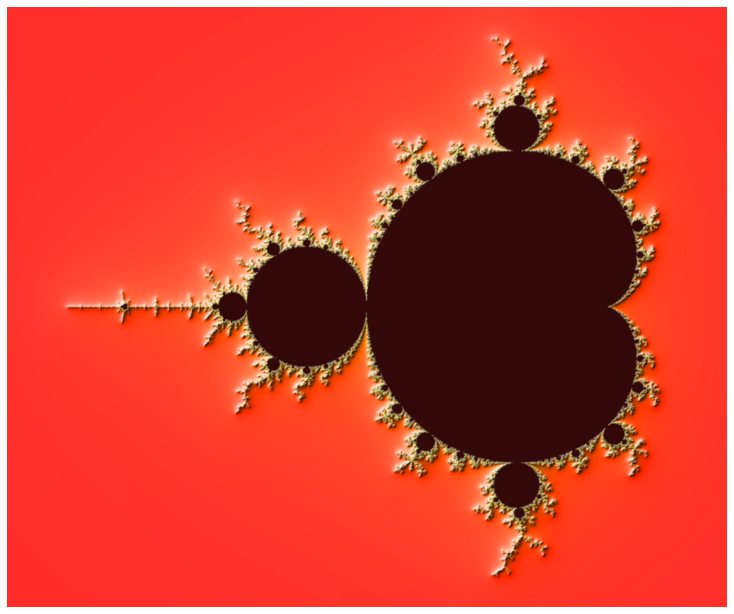

In [29]:
from matplotlib import colors

xmin, xmax, xn = -2.25, +0.75, int(3000/2)
ymin, ymax, yn = -1.25, +1.25, int(2500/2)
maxiter = 200
horizon = 2.0 ** 40
log_horizon = np.log(np.log(horizon))/np.log(2)
Z, N = mandelbrot_numpy_2(xmin, xmax, ymin, ymax, xn, yn, maxiter, horizon)

# Normalized recount as explained in:
# http://linas.org/art-gallery/escape/smooth.html
M = np.nan_to_num(N + 1 - np.log(np.log(abs(Z)))/np.log(2) + log_horizon)

dpi = 72
width = 10
height = 10*yn/xn

fig = plt.figure(figsize=(width, height), dpi=dpi)
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False, aspect=1)

light = colors.LightSource(azdeg=315, altdeg=10)
plt.imshow(light.shade(M, cmap=plt.cm.hot, vert_exag=1.5,
					   norm = colors.PowerNorm(0.3), blend_mode='hsv'),
		   extent=[xmin, xmax, ymin, ymax], interpolation="bicubic")
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig("../data/mandelbrot.png")
#plt.show()

### Exercise

We now want to measure the fractal dimension of the Mandelbrot set using the
[Minkowski–Bouligand dimension]
(https://en.wikipedia.org/wiki/Minkowski–Bouligand_dimension). 
**To do that, we need to do box-counting with a decreasing box size (see figure below)**. 
As you can imagine, we cannot use pure Python because it would be way too slow. 

The goal of the exercise is to write a function using numpy that takes a two-dimensional
float array and returns the dimension. 
We'll consider values in the array to be normalized (i.e. all values are between 0 and 1).

**Figure 4.7**. The Minkowski–Bouligand dimension of the Great Britain coastlines is
   approximately 1.24.
<img src = 'https://drive.google.com/uc?id=1qjK5Ipb5rvE1lIIdThGgD24nBuQegHrv'>

fractal-dimension.py (solution to the exercise)

In [0]:
def fractal_dimension(Z, threshold=0.9):
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)
        return len(np.where((S > 0) & (S < k*k))[0])
    Z = (Z < threshold)
    p = min(Z.shape)
    n = 2**np.floor(np.log(p)/np.log(2))
    n = int(np.log(n)/np.log(2))
    sizes = 2**np.arange(n, 1, -1)
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]


if __name__ == '__main__':
    from scipy import misc
    import matplotlib.patches as patches

    Z = 1.0 - misc.imread("../data/Great-Britain.png")/255

    print(fractal_dimension(Z, threshold=0.25))

    sizes = 128, 64, 32
    xmin, xmax = 0, Z.shape[1]
    ymin, ymax = 0, Z.shape[0]
    fig = plt.figure(figsize=(10, 5))

    for i, size in enumerate(sizes):
        ax = plt.subplot(1, len(sizes), i+1, frameon=False)
        ax.imshow(1-Z, plt.cm.gray, interpolation="bicubic", vmin=0, vmax=1,
                  extent=[xmin, xmax, ymin, ymax], origin="upper")
        ax.set_xticks([])
        ax.set_yticks([])
        for y in range(Z.shape[0]//size+1):
            for x in range(Z.shape[1]//size+1):
                s = (Z[y*size:(y+1)*size, x*size:(x+1)*size] > 0.25).sum()
                if s > 0 and s < size*size:
                    rect = patches.Rectangle(
                        (x*size, Z.shape[0]-1-(y+1)*size),
                        width=size, height=size,
                        linewidth=.5, edgecolor='.25',
                        facecolor='.75', alpha=.5)
                    ax.add_patch(rect)

    plt.tight_layout()
    #plt.savefig("fractal-dimension.png")
    plt.show()


### References

* [How To Quickly Compute the Mandelbrot Set in Python](https://www.ibm.com/developerworks/community/blogs/jfp/entry/How_To_Compute_Mandelbrodt_Set_Quickly?lang=en), Jean Francois Puget, 2015.
* [My Christmas Gift: Mandelbrot Set Computation In Python](https://www.ibm.com/developerworks/community/blogs/jfp/entry/My_Christmas_Gift?lang=en), Jean Francois Puget, 2015.
* [Fast fractals with Python and Numpy](https://thesamovar.wordpress.com/2009/03/22/fast-fractals-with-python-and-numpy/), Dan Goodman, 2009.
* [Renormalizing the Mandelbrot Escape](http://linas.org/art-gallery/escape/escape.html), Linas Vepstas, 1997.

## Spatial vectorization

----

**Spatial vectorization** refers to a situation where elements share the same computation but are in interaction with only a subgroup of other elements. 

----

This was already the case for the game of life example, but in some situations there is an added difficulty because **the subgroup is dynamic and needs to be updated at each iteration**. 
This the case, for example, in **particle systems** where **particles interact mostly with local neighbours**. 
This is also the case for **boids** that simulate flocking behaviors.

**Figure 8**. Flocking birds are an example of self-organization in biology. Image by [Christoffer A Rasmussen](https://commons.wikimedia.org/wiki/File:Fugle,_ørnsø_073.jpg), 2012.
<img src = 'https://drive.google.com/uc?id=1Py5giHJ0dUPGA-wO1DuRVZXikFZaglC_'>

### Boids

**Boids is an artificial life program**, developed by Craig Reynolds in 1986, which simulates the **flocking behaviour of birds**. 
The name **boid** corresponds to a shortened version of **bird-oid object**, which refers to a bird-like object.

As with most artificial life simulations, Boids is an example of emergent behavior; that is, the complexity of Boids arises from the interaction of individual agents (the boids, in this case) adhering to a set of simple rules. 
The rules applied in the simplest Boids world are as follows:

* **separation**: steer to avoid crowding local flock-mates
* **alignment**: steer towards the average heading of local flock-mates
* **cohesion**: steer to move toward the average position (center of mass) of local flock-mates

**Figure 9**. Boids are governed by a set of **three local rules** (separation, cohesion and
   alignment) that serve as computing **velocity** and **acceleration**.
   <img  src = 'https://drive.google.com/uc?id=1QPuCDSVK-oVVG_U7KVk8u_3m5WVhbf9F'>
   

### Python implementation

Since each boid is an autonomous entity with several properties such as position and velocity, it seems natural to start by writing a Boid class:

In [0]:
   import math
   import random
   from vec2 import vec2

   class Boid:
       def __init__(self, x=0, y=0):
           self.position = vec2(x, y)
           angle = random.uniform(0, 2*math.pi)
           self.velocity = vec2(math.cos(angle), math.sin(angle))
           self.acceleration = vec2(0, 0)

**The `vec2` object is a very simple class that handles all common vector operations with 2 components.** 
It will save us some writing in the main `Boid` class. 
Note that there are some vector packages in the Python Package Index, but that would be overkill for such a simple example.

Boid is a difficult case for regular Python because a **boid has interaction with local neighbours**. 
However, and because boids are moving, **to find such local neighbours requires computing at each time step the distance to each and every other boid in order to sort those which are in a given interaction radius**. 
The prototypical way of writing the three rules is thus something like:

In [0]:
    # Separation
    # Method checks for nearby boids and steers away
    def separate(self, boids):
        desired_separation = 25.0
        steer = vec2(0, 0)
        count = 0

        # For every boid in the system, check if it's too close
        for other in boids:
            d = (self.position - other.position).length()
            # If the distance is greater than 0 and less than an arbitrary
            # amount (0 when you are yourself)
            if 0 < d < desired_separation:
                # Calculate vector pointing away from neighbor
                diff = self.position - other.position
                diff = diff.normalized()
                steer += diff/d  # Weight by distance
                count += 1       # Keep track of how many

        # Average - divide by how many
        if count > 0:
            steer /= count

        # As long as the vector is greater than 0
        if steer.length() > 0:
            # Implement Reynolds: Steering = Desired - Velocity
            steer = steer.normalized()
            steer *= self.max_velocity
            steer -= self.velocity
            steer = steer.limited(self.max_acceleration)

        return steer

    # Alignment
    # For every nearby boid in the system, calculate the average velocity
    def align(self, boids):
        neighbor_dist = 50
        sum = vec2(0, 0)
        count = 0
        for other in boids:
            d = (self.position - other.position).length()
            if 0 < d < neighbor_dist:
                sum += other.velocity
                count += 1

        if count > 0:
            sum /= count
            # Implement Reynolds: Steering = Desired - Velocity
            sum = sum.normalized()
            sum *= self.max_velocity
            steer = sum - self.velocity
            steer = steer.limited(self.max_acceleration)
            return steer
        else:
            return vec2(0, 0)

    # Cohesion
    # For the average position (i.e. center) of all nearby boids, calculate
    # steering vector towards that position
    def cohesion(self, boids):
        neighbor_dist = 50
        sum = vec2(0, 0)  # Start with empty vector to accumulate all positions
        count = 0
        for other in boids:
            d = (self.position - other.position).length()
            if 0 < d < neighbor_dist:
                sum += other.position  # Add position
                count += 1
        if count > 0:
            sum /= count
            return self.seek(sum)
        else:
            return vec2(0, 0)

Full sources are given in the references section below, it would be too long to describe it here and there is no real difficulty.

To complete the picture, we can also create a `Flock` object:

In [0]:
   class Flock:
       def __init__(self, count=150):
           self.boids = []
           for i in range(count):
               boid = Boid()
               self.boids.append(boid)

       def run(self):
           for boid in self.boids:
               boid.run(self.boids)

Using this approach, we can have up to 50 boids until the computation time becomes too slow for a smooth animation. 

As you may have guessed, we can do much better using numpy, but let me first point out the main problem with this Python implementation. 
* If you look at the code, you will certainly notice there is a lot of redundancy. 
  * More precisely, we do not exploit the fact that **the Euclidean distance is reflexive**, that
is, $|x-y| = |y-x|$. 
* In this naive Python implementation, each rule (function) computes $n^2$ distances while
$\frac{n^2}{2}$ would be sufficient if properly cached. 
* Furthermore, each rule re-computes every distance without caching the result for the other functions. 
In the end, we are computing $3n^2$ distances instead of $\frac{n^2}{2}$.

### CODE: boid-*python*

In [0]:
import math
import random
from collections import namedtuple

In [0]:
def struct(name, members):
    cls = namedtuple(name, members)
    cls.__repr__ = lambda self: "%s(%s)" % (name, ','.join(str(s) for s in self))
    return cls


class vec2(struct('vec2', ('x', 'y'))):

    def __add__(self, other):
        if isinstance(other, vec2):
            return vec2(self.x+other.x, self.y+other.y)
        return vec2(self.x+other, self.y+other)

    def __sub__(self, other):
        if isinstance(other, vec2):
            return vec2(self.x-other.x, self.y-other.y)
        return vec2(self.x-other, self.y-other)

    def __mul__(self, other):
        if isinstance(other, vec2):
            return vec2(self.x*other.x, self.y*other.y)
        return vec2(self.x*other, self.y*other)

    def __truediv__(self, other):
        if isinstance(other, vec2):
            return vec2(self.x/other.x, self.y/other.y)
        return vec2(self.x/other, self.y/other)

    def length(self):
        return math.hypot(self.x, self.y)

    def normalized(self):
        length = self.length()
        if not length:
            length = 1.0
        return vec2(self.x/length, self.y/length)

    def limited(self, maxlength=1.0):
        length = self.length()
        if length > maxlength:
            return vec2(maxlength*self.x/length, maxlength*self.y/length)
        return self

In [0]:
class Boid:
    def __init__(self, x, y):
        self.acceleration = vec2(0, 0)
        angle = random.uniform(0, 2*math.pi)
        self.velocity = vec2(math.cos(angle), math.sin(angle))
        self.position = vec2(x, y)
        self.r = 2.0
        self.max_velocity = 2
        self.max_acceleration = 0.03

    def seek(self, target):
        desired = target - self.position
        desired = desired.normalized()
        desired *= self.max_velocity
        steer = desired - self.velocity
        steer = steer.limited(self.max_acceleration)
        return steer

    # Wraparound
    def borders(self):
        x, y = self.position
        x = (x+self.width) % self.width
        y = (y+self.height) % self.height
        self.position = vec2(x,y)

    # Separation
    # Method checks for nearby boids and steers away
    def separate(self, boids):
        desired_separation = 25.0
        steer = vec2(0, 0)
        count = 0

        # For every boid in the system, check if it's too close
        for other in boids:
            d = (self.position - other.position).length()
            # If the distance is greater than 0 and less than an arbitrary
            # amount (0 when you are yourself)
            if 0 < d < desired_separation:
                # Calculate vector pointing away from neighbor
                diff = self.position - other.position
                diff = diff.normalized()
                steer += diff/d  # Weight by distance
                count += 1       # Keep track of how many

        # Average - divide by how many
        if count > 0:
            steer /= count

        # As long as the vector is greater than 0
        if steer.length() > 0:
            # Implement Reynolds: Steering = Desired - Velocity
            steer = steer.normalized()
            steer *= self.max_velocity
            steer -= self.velocity
            steer = steer.limited(self.max_acceleration)

        return steer

    # Alignment
    # For every nearby boid in the system, calculate the average velocity
    def align(self, boids):
        neighbor_dist = 50
        sum = vec2(0, 0)
        count = 0
        for other in boids:
            d = (self.position - other.position).length()
            if 0 < d < neighbor_dist:
                sum += other.velocity
                count += 1

        if count > 0:
            sum /= count
            # Implement Reynolds: Steering = Desired - Velocity
            sum = sum.normalized()
            sum *= self.max_velocity
            steer = sum - self.velocity
            steer = steer.limited(self.max_acceleration)
            return steer
        else:
            return vec2(0, 0)

    # Cohesion
    # For the average position (i.e. center) of all nearby boids, calculate
    # steering vector towards that position
    def cohesion(self, boids):
        neighbor_dist = 50
        sum = vec2(0, 0)  # Start with empty vector to accumulate all positions
        count = 0
        for other in boids:
            d = (self.position - other.position).length()
            if 0 < d < neighbor_dist:
                sum += other.position  # Add position
                count += 1
        if count > 0:
            sum /= count
            return self.seek(sum)
        else:
            return vec2(0, 0)

    def flock(self, boids):
        sep = self.separate(boids)  # Separation
        ali = self.align(boids)  # Alignment
        coh = self.cohesion(boids)  # Cohesion

        # Arbitrarily weight these forces
        sep *= 1.5
        ali *= 1.0
        coh *= 1.0

        # Add the force vectors to acceleration
        self.acceleration += sep
        self.acceleration += ali
        self.acceleration += coh

    def update(self):
        # Update velocity
        self.velocity += self.acceleration
        # Limit speed
        self.velocity = self.velocity.limited(self.max_velocity)
        self.position += self.velocity
        # Reset acceleration to 0 each cycle
        self.acceleration = vec2(0, 0)

    def run(self, boids):
        self.flock(boids)
        self.update()
        self.borders()


class Flock:
    def __init__(self, count=150, width=640, height=360):
        self.width = width
        self.height = height
        self.boids = []
        for i in range(count):
            boid = Boid(width/2, height/2)
            boid.width = width
            boid.height = height
            self.boids.append(boid)

    def run(self):
        for boid in self.boids:
            # Passing the entire list of boids to each boid individually
            boid.run(self.boids)

    def cohesion(self, boids):
        P = np.zeros((len(boids),2))
        for i, boid in enumerate(self.boids):
            P[i] = boid.cohesion(self.boids)
        return P

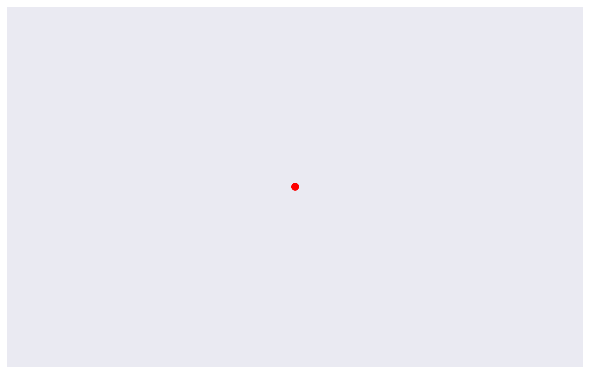

In [7]:
from matplotlib.animation import FuncAnimation

n=50
flock = Flock(n)
P = np.zeros((n,2))

def update(*args):
    flock.run()
    for i,boid in enumerate(flock.boids):
        P[i] = boid.position
    scatter.set_offsets(P)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=True)
scatter = ax.scatter(P[:,0], P[:,1],
                     s=30, facecolor="red", edgecolor="None", alpha=0.5)

animation = FuncAnimation(fig, update, interval=10)
ax.set_xlim(0,640)
ax.set_ylim(0,360)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Numpy implementation

As you might expect, the numpy implementation takes a different approach and we'll gather all our boids into a `position` array and a `velocity` array:

In [0]:
   n = 500
   velocity = np.zeros((n, 2), dtype=np.float32)
   position = np.zeros((n, 2), dtype=np.float32)

The first step is to compute the local neighborhood for all boids, and for this **we need to compute all paired distances**:

In [0]:
   dx = np.subtract.outer(position[:, 0], position[:, 0])
   dy = np.subtract.outer(position[:, 1], position[:, 1])
   distance = np.hypot(dx, dy)

We could have used the scipy [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)
but we'll need the `dx` and `dy` arrays later. 
Once those have been computed, it is faster to use the [hypot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.hypot.html)
method. 
Note that distance shape is `(n, n)` and each line relates to one boid, i.e. each line gives the distance to all other boids (including self).

**From theses distances, we can now compute the local neighborhood for each of the three rules**, taking advantage of the fact that we can mix them together. 
* We can actually compute a mask for distances that are strictly positive (i.e. have no self-interaction) and multiply it with other distance masks.


In [0]:
   mask_0 = (distance > 0)
   mask_1 = (distance < 25)
   mask_2 = (distance < 50)
   mask_1 *= mask_0
   mask_2 *= mask_0
   mask_3 = mask_2

Then, we compute the number of neighbours within the given radius and we ensure it is at least 1 to avoid division by zero.

In [0]:
mask_1_count = np.maximum(mask_1.sum(axis=1), 1)
mask_2_count = np.maximum(mask_2.sum(axis=1), 1)
mask_3_count = mask_2_count

We're ready to write our three rules:

#### Alignment

In [0]:
   # Compute the average velocity of local neighbours
   target = np.dot(mask, velocity)/count.reshape(n, 1)

   # Normalize the result
   norm = np.sqrt((target*target).sum(axis=1)).reshape(n, 1)
   target *= np.divide(target, norm, out=target, where=norm != 0)

   # Alignment at constant speed
   target *= max_velocity

   # Compute the resulting steering
   alignment = target - velocity

#### Cohesion

In [0]:
   # Compute the gravity center of local neighbours
   center = np.dot(mask, position)/count.reshape(n, 1)

   # Compute direction toward the center
   target = center - position

   # Normalize the result
   norm = np.sqrt((target*target).sum(axis=1)).reshape(n, 1)
   target *= np.divide(target, norm, out=target, where=norm != 0)

   # Cohesion at constant speed (max_velocity)
   target *= max_velocity

   # Compute the resulting steering
   cohesion = target - velocity

#### Separation

In [0]:
   # Compute the repulsion force from local neighbours
   repulsion = np.dstack((dx, dy))

   # Force is inversely proportional to the distance
   repulsion = np.divide(repulsion, distance.reshape(n, n, 1)**2, out=repulsion,
                         where=distance.reshape(n, n, 1) != 0)

   # Compute direction away from others
   target = (repulsion*mask.reshape(n, n, 1)).sum(axis=1)/count.reshape(n, 1)

   # Normalize the result
   norm = np.sqrt((target*target).sum(axis=1)).reshape(n, 1)
   target *= np.divide(target, norm, out=target, where=norm != 0)

   # Separation at constant speed (max_velocity)
   target *= max_velocity

   # Compute the resulting steering
   separation = target - velocity

All three resulting steerings (separation, alignment & cohesion) need to be limited in magnitude. 
We leave this as an exercise for the reader. 

Combination of these rules is straightforward as well as the resulting update of velocity and position:

In [0]:
   acceleration = 1.5 * separation + alignment + cohesion
   velocity += acceleration
   position += velocity

We finally visualize the result using a custom oriented scatter plot.

**Figure 10**. Boids is an artificial life program, developed by Craig Reynolds in 1986,
   which simulates the flocking behaviour of birds.

### CODE: boid-*numpy*

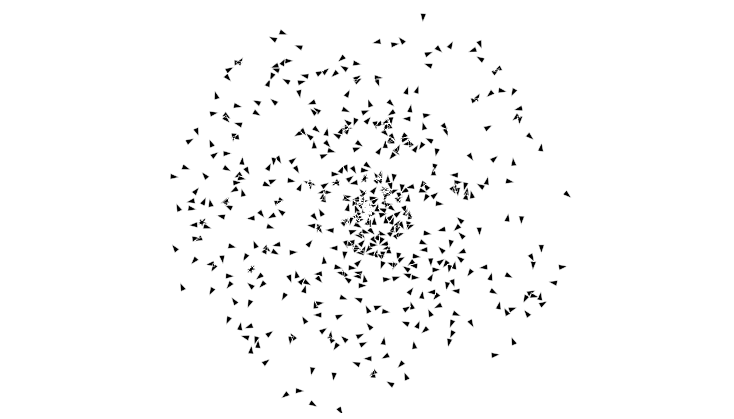

In [9]:
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PathCollection


class MarkerCollection:
    """
    Marker collection
    """

    def __init__(self, n=100):
        v = np.array([(-0.25, -0.25), (+0.0, +0.5), (+0.25, -0.25), (0, 0)])
        c = np.array([Path.MOVETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY])
        self._base_vertices = np.tile(v.reshape(-1), n).reshape(n, len(v), 2)
        self._vertices = np.tile(v.reshape(-1), n).reshape(n, len(v), 2)
        self._codes = np.tile(c.reshape(-1), n)

        self._scale = np.ones(n)
        self._translate = np.zeros((n, 2))
        self._rotate = np.zeros(n)

        self._path = Path(vertices=self._vertices.reshape(n*len(v), 2),
                          codes=self._codes)
        self._collection = PathCollection([self._path], linewidth=0.5,
                                          facecolor="k", edgecolor="w")

    def update(self):
        n = len(self._base_vertices)
        self._vertices[...] = self._base_vertices * self._scale
        cos_rotate, sin_rotate = np.cos(self._rotate), np.sin(self._rotate)
        R = np.empty((n, 2, 2))
        R[:, 0, 0] = cos_rotate
        R[:, 1, 0] = sin_rotate
        R[:, 0, 1] = -sin_rotate
        R[:, 1, 1] = cos_rotate
        self._vertices[...] = np.einsum('ijk,ilk->ijl', self._vertices, R)
        self._vertices += self._translate.reshape(n, 1, 2)


class Flock:
    def __init__(self, count=500, width=640, height=360):
        self.width = width
        self.height = height
        self.min_velocity = 0.5
        self.max_velocity = 2.0
        self.max_acceleration = 0.03
        self.velocity = np.zeros((count, 2), dtype=np.float32)
        self.position = np.zeros((count, 2), dtype=np.float32)

        angle = np.random.uniform(0, 2*np.pi, count)
        self.velocity[:, 0] = np.cos(angle)
        self.velocity[:, 1] = np.sin(angle)
        angle = np.random.uniform(0, 2*np.pi, count)
        radius = min(width, height)/2*np.random.uniform(0, 1, count)
        self.position[:, 0] = width/2 + np.cos(angle)*radius
        self.position[:, 1] = height/2 + np.sin(angle)*radius

    def run(self):
        position = self.position
        velocity = self.velocity
        min_velocity = self.min_velocity
        max_velocity = self.max_velocity
        max_acceleration = self.max_acceleration
        n = len(position)

        dx = np.subtract.outer(position[:, 0], position[:, 0])
        dy = np.subtract.outer(position[:, 1], position[:, 1])
        distance = np.hypot(dx, dy)

        # Compute common distance masks
        mask_0 = (distance > 0)
        mask_1 = (distance < 25)
        mask_2 = (distance < 50)
        mask_1 *= mask_0
        mask_2 *= mask_0
        mask_3 = mask_2
        mask_1_count = np.maximum(mask_1.sum(axis=1), 1)
        mask_2_count = np.maximum(mask_2.sum(axis=1), 1)
        mask_3_count = mask_2_count

        # Separation
        mask, count = mask_1, mask_1_count
        target = np.dstack((dx, dy))
        target = np.divide(target, distance.reshape(n, n, 1)**2, out=target,
                           where=distance.reshape(n, n, 1) != 0)
        steer = (target*mask.reshape(n, n, 1)).sum(axis=1)/count.reshape(n, 1)
        norm = np.sqrt((steer*steer).sum(axis=1)).reshape(n, 1)
        steer = max_velocity*np.divide(steer, norm, out=steer,
                                       where=norm != 0)
        steer -= velocity

        # Limit acceleration
        norm = np.sqrt((steer*steer).sum(axis=1)).reshape(n, 1)
        steer = np.multiply(steer, max_acceleration/norm, out=steer,
                            where=norm > max_acceleration)

        separation = steer

        # Alignment
        # ---------------------------------------------------------------------
        # Compute target
        mask, count = mask_2, mask_2_count
        target = np.dot(mask, velocity)/count.reshape(n, 1)

        # Compute steering
        norm = np.sqrt((target*target).sum(axis=1)).reshape(n, 1)
        target = max_velocity * np.divide(target, norm, out=target,
                                          where=norm != 0)
        steer = target - velocity

        # Limit acceleration
        norm = np.sqrt((steer*steer).sum(axis=1)).reshape(n, 1)
        steer = np.multiply(steer, max_acceleration/norm, out=steer,
                            where=norm > max_acceleration)
        alignment = steer

        # Cohesion
        # ---------------------------------------------------------------------
        # Compute target
        mask, count = mask_3, mask_3_count
        target = np.dot(mask, position)/count.reshape(n, 1)

        # Compute steering
        desired = target - position
        norm = np.sqrt((desired*desired).sum(axis=1)).reshape(n, 1)
        desired *= max_velocity / norm
        steer = desired - velocity

        # Limit acceleration
        norm = np.sqrt((steer*steer).sum(axis=1)).reshape(n, 1)
        steer = np.multiply(steer, max_acceleration/norm, out=steer,
                            where=norm > max_acceleration)
        cohesion = steer

        # ---------------------------------------------------------------------
        acceleration = 1.5 * separation + alignment + cohesion
        velocity += acceleration

        norm = np.sqrt((velocity*velocity).sum(axis=1)).reshape(n, 1)
        velocity = np.multiply(velocity, max_velocity/norm, out=velocity,
                               where=norm > max_velocity)
        velocity = np.multiply(velocity, min_velocity/norm, out=velocity,
                               where=norm < min_velocity)
        position += velocity

        # Wraparound
        position += (self.width, self.height)
        position %= (self.width, self.height)


def update(*args):
    global flock, collection, trace

    # Flock updating
    flock.run()
    collection._scale = 10
    collection._translate = flock.position
    collection._rotate = -np.pi/2 + np.arctan2(flock.velocity[:, 1],
                                               flock.velocity[:, 0])
    collection.update()

    # Trace updating
    if trace is not None:
        P = flock.position.astype(int)
        trace[height-1-P[:, 1], P[:, 0]] = .75
        trace *= .99
        im.set_array(trace)


# -----------------------------------------------------------------------------
if __name__ == '__main__':

    n = 500
    width, height = 640, 360
    flock = Flock(n)
    fig = plt.figure(figsize=(10, 10*height/width), facecolor="white")
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], aspect=1, frameon=False)
    collection = MarkerCollection(n)
    ax.add_collection(collection._collection)
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.set_xticks([])
    ax.set_yticks([])

    # Trace
    trace = None
    if 0:
        trace = np.zeros((height, width))
        im = ax.imshow(trace, extent=[0, width, 0, height], vmin=0, vmax=1,
                       interpolation="nearest", cmap=plt.cm.gray_r)

    animation = FuncAnimation(fig, update, interval=10, frames=1000)
    #animation.save('boid.mp4', fps=40, dpi=80, bitrate=-1, codec="libx264",
    #               extra_args=['-pix_fmt', 'yuv420p'],
    #               metadata={'artist': 'Nicolas P. Rougier'})
    plt.show()


### Exercise

We are now ready to visualize our boids. The easiest way is to use the matplotlib animation function and a scatter plot. 
Unfortunately, scatters cannot be individually oriented and we need to make our own objects using a matplotlib `PathCollection`. A simple triangle path can be defined as:

In [0]:
   v= np.array([(-0.25, -0.25),
                ( 0.00,  0.50),
                ( 0.25, -0.25),
                ( 0.00,  0.00)])
   c = np.array([Path.MOVETO,
                 Path.LINETO,
                 Path.LINETO,
                 Path.CLOSEPOLY])

This path can be repeated several times inside an array and each triangle can be made independent.

In [0]:
n = 500
vertices = np.tile(v.reshape(-1), n).reshape(n, len(v), 2)
codes = np.tile(c.reshape(-1), n)

We now have a `(n,4,2)` array for vertices and a `(n,4)` array for codes representing `n` boids. We are interested in manipulating the vertices array to reflect the translation, scaling and rotation of each of the `n` boids.

### References

* [Flocking](https://processing.org/examples/flocking.html), Daniel Shiffman, 2010.
* [Flocks, herds and schools: A distributed behavioral model](http://www.red3d.com/cwr/boids/), Craig Reynolds, SIGGRAPH, 1987


## Conclusion


We've seen through these examples three forms of code vectorization:

* **uniform vectorization** where elements share the same computation unconditionally and for the same duration.
* **temporal vectorization** where elements share the same computation but necessitate a different number of iterations.
* **spatial vectorization** where elements share the same computation but on dynamic spatial arguments.

And there are probably many more forms of such direct code vectorization. 
As explained before, this kind of vectorization is one of the most simple even though we've seen it can be really tricky to implement and requires some experience, some help or both. 
* For example, the solution to the boids exercise was provided by [Divakar](http://stackoverflow.com/users/3293881/divakar) on [stack overflow](http://stackoverflow.com/questions/40822983/multiple-individual-2d-rotation-at-once) after having explained my problem.
